In [2]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

# NOTE: PANDAS DATAFRAMES ALIGN WITH MATHEMATICAL INDEXING CONVENTION FOR MATRICES BY USING df.iloc
np.random.seed(10)

In [2]:
def sigmoid(x, k=5):
    """
    Calculate the sigmoid function.
    
    Parameters:
    x (float): The input value to the sigmoid function.
    k (float): The steepness of the sigmoid curve.
    
    Returns:
    float: The output of the sigmoid function.
    """
    return 1 / (1 + np.exp(-k * x))
    # return 1

# Assumptions and Important Model Features

- Each industry $j$ aims to keep a target inventory $n_j$ $Z_{ij, 0}$ of every required input $i$ to ensure production for $n_j$ futher days
- The simulation starts where each industry's inventory equals their target inventory: $n_j$ $Z_{ij, 0}$
- One time step ($t$) indicates ONE DAY
- Initially every industry employs $l_{i, 0}$ of labour and produces at FULL CAPACITY: $x^{cap}_{i, 0}$ $=$ $x_{i, 0}$
- Assumption: Productive capacity depends linearly on labour inputs, so $x^{cap}_{i, t}$ $=$ $\frac{l_{i, t}}{l_{i, 0}}$ $x^{cap}_{i, 0}$

- Every day, firms hire or fire workers depending on whether their labour force was insufficient or redundant to carry out production in the previous day
- If industries do not produce enough, they distribute their production to final consumers and other industries on a pro-rata basis (proportionally to demand)
- Industries update their inventory levels

# Initialising N (number of industries) $x_{j,0}$ (initial output of every $j^{th}$ industry), $Z_{ij, 0}$ (initial intermediate consumption variables)

# Initialising $S_{ij, 0}$ (initial inventory of good $i$ in industry $j$) assuming $n_j$ (keeping enough inventory for production to last 7-15 days)

In [3]:
# Constructing IO_matrix
np.random.seed(42)

# Define the size of the input-output matrix
num_industries = 3  # Change this to your desired number of industries N

def set_x_z_s(x_mean, x_sigma, Z_mean, Z_sigma, c, f):
    # Generate random values for x_j from log-normal distribution
    x_initial = np.random.lognormal(mean=x_mean, sigma=x_sigma, size=num_industries)  # gross output of every industry j ( x_j )
    # x_initial = x_initial.astype(np.float128)

    # Generate random values for Z_ij_0 based on the relation A_ij = Z_ij_0 / x_j_0
    Z_initial = np.zeros(shape=(num_industries, num_industries)) # intermediate consumption of industry j of good i ( Z_{ij} )
    # Z_initial = np.zeros(shape=(num_industries, num_industries), dtype=np.float128)

    for i in range(num_industries):
        for j in range(num_industries):
            Z_initial[i][j] = np.random.lognormal(mean=Z_mean, sigma=Z_sigma) 
    
    # normalisation_constant = c + f
    constraints = c + f

    # Enforcing the following constraint... sum over j: Z_{ij, 0} <= x_{i, 0} + c_{i, 0} + f_{i, 0}
    for i in range(num_industries):
        scaling_factor = np.sum(Z_initial[i, :]) / constraints[i]
        Z_initial[i, :] *= scaling_factor

    for i in range(num_industries):
        row_sum = np.sum(Z_initial[i, :]) / x_initial[i]
        Z_initial[i, :] = Z_initial[i, :] / row_sum
    

    
    # Compute the IO_matrix (A)
    IO_matrix = np.divide(Z_initial, x_initial[:, np.newaxis]) # rows sum to 1
    IO_matrix = IO_matrix / 10 # rows sum to 0.1

    # Compute the input-output matrix A based on the relation A_ij = Z_ij_0 / x_j_0
    # IO_matrix = np.divide(Z_initial, x_initial)  # Corrected indexing

    # x_{i, 0} should always be larger than sum over j Z_{ij, 0}

    # sum over j: Z_{ij, 0} <= x_{i, 0} + c_{i, 0} + f_{i, 0}
 
    # S = np.zeros(shape=(num_industries, num_industries), dtype=np.float128) # Inventory for every industry j of every good i (S_{ij})

    S = np.zeros(shape=(num_industries, num_industries))

    n = np.random.randint(1, 7, size=num_industries) # When calibrating this, there will be a different CALIBRATED n[j] for every j.th industry in reality (this is temporary)
    
    S = np.multiply(n, Z_initial)
    
    target_inventory = np.copy(S) # Each industry j aims to keep a target inventory n_j * Z_ij,0 of every required input
    
    return x_initial, Z_initial, IO_matrix, S, target_inventory, n

x_initial, Z_initial, IO_matrix, S, target_inventory, n = set_x_z_s(x_mean=3, x_sigma=1, Z_mean=2.7, Z_sigma=1)

IO_matrix = IO_matrix.astype(np.float64)

eigenvalues, eigenvectors = np.linalg.eig(IO_matrix)

IO_matrix
IO_matrix, Z_initial, x_initial,

# Initialising $l_{i, 0}$ (Initial Labour Compensation of every $i^{th}$ industry), $d_{i, 0}$ (initial demand for every good $i$)

In [4]:
def set_labour_demand(industry_labour_comp_mean, industry_labour_comp_sigma, industry_demand_mean, industry_demand_sigma):
    industry_labour_comp = np.random.lognormal(mean=industry_labour_comp_mean, sigma=industry_labour_comp_sigma, size=num_industries) # l_{i, t} ( = l_{i, 0} at this point)
    # industry_labour_comp = industry_labour_comp.astype(np.float128)
    initial_industry_labour_comp = np.copy(industry_labour_comp) # l_{i, 0}

    industry_demand = np.random.lognormal(mean=industry_demand_mean, sigma=industry_demand_sigma, size=num_industries) # d_{i, 0}
    # industry_demand = industry_demand.astype(np.float128)

    initial_industry_demand = np.copy(industry_demand)
    
    return industry_labour_comp, initial_industry_labour_comp, industry_demand, initial_industry_demand

# industry_labour_comp, initial_industry_labour_comp, industry_demand, initial_industry_demand = set_labour_demand(industry_labour_comp_mean=1, industry_labour_comp_sigma=0.3, industry_demand_mean=2.8, industry_demand_sigma=1)

# Further convenient and parameter initialisations (demand non household final demand of good i, Demand of household consumption of good i, upward and downward labour adjustments, consumption adjustment, Inventory Adjustment, initial total labour compensation)

In [5]:
def set_final_demands(demand_non_household_final_demand_mean, demand_non_household_final_demand_sigma, demand_household_consumption_mean, demand_household_consumption_sigma):
    demand_non_household_final_demand = np.random.lognormal(mean=demand_non_household_final_demand_mean, sigma=demand_non_household_final_demand_sigma, size=num_industries) # f^d_{i, t} = f^d_{i, 0} government taxes, expensses, etc...
    # demand_non_household_final_demand = demand_non_household_final_demand.astype(dtype=np.float128)

    initial_demand_non_household_final_demand = demand_non_household_final_demand

    demand_household_consumption = np.random.lognormal(mean = demand_household_consumption_mean, sigma=demand_household_consumption_sigma, size=num_industries) # c^d_{i, t}, household consumption
    # demand_household_consumption = demand_household_consumption.astype(dtype=np.float128)

    initial_demand_household_consumption = demand_household_consumption
    
    return demand_non_household_final_demand, initial_demand_non_household_final_demand, demand_household_consumption, initial_demand_household_consumption
    
# demand_non_household_final_demand, initial_demand_non_household_final_demand, demand_household_consumption, initial_demand_household_consumption = set_final_demands(demand_non_household_final_demand_mean=0.9, demand_non_household_final_demand_sigma=0.5, demand_household_consumption_mean=0.95, demand_household_consumption_sigma=0.5)

def set_coefficients(initial_industry_labour_comp, x_initial):
    inventory_adjustment = 10 # Tau

    # We ASSUME downward labour adjustment > upward labour adjustment BECAUASE it is easier to fire workers than hire workers
    # downward_labour_adjustment = 1 / 15

    downward_labour_adjustment = 1/40
    upward_labour_adjustment = 1 / 50
    consumption_adjustment = 0.6

    initial_total_labour_compensation = np.sum(initial_industry_labour_comp)

    total_labour_compensation = initial_total_labour_compensation

    total_permanent_labour_compensation = initial_total_labour_compensation

    Labour_share = np.divide(initial_industry_labour_comp, x_initial) # Labour share in production is assumed constant
    
    return inventory_adjustment, downward_labour_adjustment, upward_labour_adjustment, consumption_adjustment, initial_total_labour_compensation, total_labour_compensation, total_permanent_labour_compensation, Labour_share

# inventory_adjustment, downward_labour_adjustment, upward_labour_adjustment, consumption_adjustment, initial_total_labour_compensation, total_labour_compensation, total_permanent_labour_compensation, Labour_share = set_coefficients(initial_industry_labour_comp=initial_industry_labour_comp, x_initial=x_initial)

# Initially every industry employs $l_{i,0}$ of labor and produces at full capacity $x^{cap}_{i, 0} = x_{i,0}$

# $x^{inp}_{i, t} = min \{ \frac{S_{ji, t}} {A_{ji}} \}$ however it can be proven that INITIALLY $x^{inp}_{i, 0} = n_i . x_{i, 0}$

Given the following $A_{ji} = \frac{Z_{ji, 0}} {x_{i, 0}}$, $S_{ji, 0} = n_i . Z_{ij, 0}$, and $x^{inp}_{i, t} = min \{ \frac{S_{ji, t}} {A_{ji}} \}$

$S_{ji, 0} = n_{i} . Z_{ji, 0}$

$x^{inp}_{i, 0} = min \{ \frac{S_{ji, 0}} {A_{ji}} \}$

$\frac{S_{ji, 0}} {A_{ji}} = \frac{n_{i} . Z_{ji, 0}}{\left( \frac{Z_{ji, 0}} {x_{i, 0}}\right)}$

$ = \frac{n_{i} . Z_{ji, 0} . x_{i, 0}}{Z_{ji, 0}} $

$ = n_{i} . x_{i, 0} $

$\therefore  x^{inp}_{i, 0} = n_i . x_{i, 0}$

In [6]:
def set_constrained_x(x_initial, n):
    labour_constrained_x = np.copy(x_initial)

    # input_constrained_x = np.zeros(shape=num_industries, dtype=np.float128)
    input_constrained_x = np.zeros(shape=num_industries)
        
    for i in range(num_industries):
        input_constrained_x[i] = n[i] * x_initial[i]

    initial_input_constrained_x = np.copy(input_constrained_x)
    
    return labour_constrained_x, input_constrained_x, initial_input_constrained_x

# Converting to dictionaries and other convenient initialisations

In [7]:
demand_non_household_final_demand, initial_demand_non_household_final_demand, demand_household_consumption, initial_demand_household_consumption = set_final_demands(demand_non_household_final_demand_mean=0.9, demand_non_household_final_demand_sigma=0.5, demand_household_consumption_mean=0.95, demand_household_consumption_sigma=0.5)
x_initial, Z_initial, IO_matrix, S, target_inventory, n = set_x_z_s(x_mean=3, x_sigma=1, Z_mean=2.7, Z_sigma=1, c=demand_household_consumption, f=demand_non_household_final_demand)

industry_labour_comp, initial_industry_labour_comp, industry_demand, initial_industry_demand = set_labour_demand(industry_labour_comp_mean=1.0, industry_labour_comp_sigma=0.5, industry_demand_mean=2.8, industry_demand_sigma=1)
inventory_adjustment, downward_labour_adjustment, upward_labour_adjustment, consumption_adjustment, initial_total_labour_compensation, total_labour_compensation, total_permanent_labour_compensation, Labour_share = set_coefficients(initial_industry_labour_comp=initial_industry_labour_comp, x_initial=x_initial)
labour_constrained_x, input_constrained_x, initial_input_constrained_x = set_constrained_x(x_initial=x_initial, n=n)

initial_labour_constrained_outputs = labour_constrained_x[0]

x = {0: np.copy(x_initial)}
Z = {0: np.copy(Z_initial)}
S = {0: np.multiply(n, Z_initial)}
industry_labour_comp = {0: initial_industry_labour_comp}
industry_demand = {0: initial_industry_demand}

demand_non_household_final_demand = {0: initial_demand_non_household_final_demand} 

demand_household_consumption = {0: initial_demand_household_consumption}

labour_constrained_x = {0: np.copy(x_initial)}

input_constrained_x = {0: initial_input_constrained_x}

industry_change_in_labour_compensation = dict()

industry_orders = dict() # O

industry_outlooks = dict()

non_household_final_demand = dict()
household_consumption = dict()

In [8]:
# TESTING

Z_initial, x_initial, demand_household_consumption, demand_non_household_final_demand

for i in range(3):
    print(  Z_initial[i][0] + Z_initial[i][1] + Z_initial[i][2] <= (x_initial[i] + initial_demand_household_consumption[i] + initial_demand_non_household_final_demand[i])  )

True
True
True


# Updating industry demand $d_{i, t}$ and inventory levels $S_{ij, t+1}$ for all $N$ industries in preparation for the first time step of our simulation

Despite $d_{i, t+1} = \sum_{j=1}^{N} O_{ij, t}*P_{t}(sum over all j: x_j, t) + f^d_{i, t} + c^d_{i, t}$

We will calculate: 

$d_{i, 1} = f^d_{i, 0} + c^d_{i, 0} \because \sum_{j=1}^{N} O_{ij, 0} = 0$ 

as no orders are made in the initial step of our simulation



# Simulation with varying Labour and Inventories

# NOTE: Focus on getting the model running and the experiment giving expected results and then utilise real-world data


TODO: Keep the structure of S as a cycle so it is easier to keep track of

TODO: Fix Divide by 0 issues by checking if a denominator is equal to 0, if so then the result should be 0 (confirmed as this being normal behaviour in our model)

TODO: Plot S, x and labour compensation as time series. \n



In [9]:
# ORIGINAL MODEL 
def run_model(days): #days = Max Iterations

    t = 0
    
    # Initially no orders are made so initial demand consists of just non household final demand and household consumption demand
    industry_demand[t+1] = demand_non_household_final_demand[t] + demand_household_consumption[t]

    x_column = x[t].reshape(-1, 1) if x[t].ndim == 1 else x[t]

    # Update inventory levels using element-wise operations for the first time step
    updated_inventory_levels = np.maximum(S[0] + Z[0] - np.multiply(IO_matrix, x_column.T), 0)        

    # S.append(pd.DataFrame(updated_inventory_levels))
    S[t+1] = np.copy(updated_inventory_levels)

    # Begin simulation at t = 1st day
    t += 1

    while t < days:
        
        # -------------- STEP 1 - Calculate new labour compensation for each INDUSTRY --------------
        current_change_in_labour_compensation = np.array([
            np.multiply(Labour_share[i], np.minimum(input_constrained_x[t - 1][i], industry_demand[t][i]) - labour_constrained_x[t - 1][i])
            for i in range(num_industries)
        ])
        

        industry_change_in_labour_compensation[t] = current_change_in_labour_compensation
        
        current_industry_labour_compensation = np.zeros(num_industries)
        
        for i in range(num_industries):
            if (industry_change_in_labour_compensation[t][i] >= 0):
                current_labour_compensation = industry_labour_comp[t - 1][i] + np.multiply(upward_labour_adjustment, industry_change_in_labour_compensation[t][i])
            if (industry_change_in_labour_compensation[t][i] < 0):
                current_labour_compensation = industry_labour_comp[t - 1][i] + np.multiply(downward_labour_adjustment, industry_change_in_labour_compensation[t][i])
                
            current_industry_labour_compensation[i] = current_labour_compensation

        industry_labour_comp[t] = current_industry_labour_compensation
        
        
        # -------------- STEP 2 - Calculating O_{ij, t} meaning the amount of good i ordered (not yet fulfilled, just ordered) by industry j (i -> j) --------------
        industry_demand_column = industry_demand[t - 1].reshape(-1, 1) if industry_demand[t-1].ndim == 1 else industry_demand[t-1]
        industry_orders[t] = np.maximum(0, np.multiply(IO_matrix, industry_demand_column.T) + np.multiply(np.divide(1, inventory_adjustment), target_inventory - S[t]))
        
        # industry_orders[t] = pd.DataFrame(industry_orders[t])
        
        # -------------- STEP 3.1 - Calculate Labour Constrained Output in current time step for each INDUSTRY --------------
        labour_constrained_x[t] = np.multiply(np.divide(industry_labour_comp[t], initial_industry_labour_comp), initial_labour_constrained_outputs)

        # -------------- STEP 3.2 - Calculate Intermediate Input Constrained Output in current time step for each INDUSTRY --------------
        bottlenecks = np.divide(S[t].T, IO_matrix.T) # S_{ji, t} / A_{ji}
        input_constrained_x[t] = np.min(bottlenecks, axis=0)

        
        # -------------- STEP 3.3 - Calculate Output based on minimum of both constrained outputs and current industry demand in current time step for each INDUSTRY --------------
        combined_constrained_outputs = np.array([labour_constrained_x[t], input_constrained_x[t], industry_demand[t]])
        x_t = np.minimum.reduce(combined_constrained_outputs, axis=0)
        x_t[x_t <= 0] = 0
        x[t] = x_t
        
        # -------------- STEP 4 - Calculate delivery of goods from industry i to industry j for every INDUSTRY based on orders from step 2 and current industry outlooks --------------
        
        ratio = np.divide(x[t], industry_demand[t], out=np.zeros_like(x[t], dtype=float), where=industry_demand[t]!=0)
        
        current_industry_outlooks = np.zeros(num_industries)
        
        # Modelling industry outlook by Sigmoid function (ratio of currrent production divided by production at full capacity - such as at time t=0)
        for i in range(num_industries):
            current_industry_outlooks[i] = sigmoid(x=np.divide(np.sum(x[t]) - x[t][i], np.sum(x[0]) - x[0][i]))

        industry_outlooks[t] = current_industry_outlooks

        # Note: we multiply by current_industry_outlooks to indicate how much each industry that ordered is ACTUALLY getting due to industry outlook
        # The corresponding proportion of each order is instead fulfilled due to industry outlook
        
        # Z_t = (industry_orders[t] * ratio[:, np.newaxis]) * current_industry_outlooks
        Z_t = (industry_orders[t] * ratio[:, np.newaxis])

        # If industry_orders[t] is a DataFrame, you can convert Z_t back to a DataFrame
        # Z_t = pd.DataFrame(Z_t, index=industry_orders[t].index, columns=industry_orders[t].columns)
        # Z.append(Z_t)
        
        Z[t] = np.maximum(0, Z_t)

        # -------------- STEP 5.1 - Calculate (demand) non household final demand (currently kept constant f^d_{t} = f^d_{0} FOR NOW ) --------------
        demand_non_household_final_demand[t] = demand_non_household_final_demand[0]
        non_household_final_demand[t] = np.multiply(demand_non_household_final_demand[t], np.divide(x[t],industry_demand[t], out=np.zeros_like(x[t], dtype=float), where=industry_demand[t]!=0))
        
        

        m = 0.82 # Using same m value from Pichler's paper
        change_in_savings_rate = 0.5
        exogenous_consumption_demand_shock = np.random.lognormal(mean=0, sigma=0.1, size=num_industries) # This reflects the unpredictable nature of exogenous consumption shocks.
        
        # Note that, in the steady state, by definition expected permanent income corresponds to current total compensation (Pichler et al. How to Restart the UK economy)
        # income, i.e.  l^p_t_total =  l_t_total, and thus total consumption demand corresponds to m * l_t_total.

        # TODO: 
        # Keep it as is now, 
        # Discuss with Paolo on the possibility of modelling permanent labour income expecation 
        # through moving average and the implications of it 

        # Muellbrauer's interpretation on how household consumption evolves through an autoregressive process with my incorporation of change in savings rate 
        # This allows us to see how the model evolves under different consumer saving behaviours (whether households choose to SAVE OR SPEND more of their income)

        # -------------- STEP 5.2 - Calculate (demand) household consumption (using autoregressive process suggested by Muellbrauer) --------------
        log_new_demand_household_consumption = np.multiply(consumption_adjustment, np.log(demand_household_consumption[t-1])) + np.multiply( 1 - consumption_adjustment, np.log(np.multiply(m, np.sum(industry_labour_comp[t]))))
        # Note: discuss the incorporation of savings rate into Muellbrauer's autoregressive model of consumption behaviour ^^
        
        # demand_household_consumption[t] = np.float128(np.exp(log_new_demand_household_consumption + exogenous_consumption_demand_shock))
        
        # demand_household_consumption[t] = np.exp(log_new_demand_household_consumption + exogenous_consumption_demand_shock)
        # demand_household_consumption[t] = demand_non_household_final_demand[0]
        demand_household_consumption[t] = demand_household_consumption[0]
        
        # household_consumption[t] = np.float128(np.multiply(demand_household_consumption[t], np.divide(x[t],industry_demand[t], out=np.zeros_like(x[t], dtype=float), where=industry_demand[t]!=0)))
        household_consumption[t] = np.multiply(demand_household_consumption[t], np.divide(x[t],industry_demand[t], out=np.zeros_like(x[t], dtype=float), where=industry_demand[t]!=0))

        # -------------- STEP 5.3 - Calculate industry demand for next time step, for EVERY INDUSTRY --------------
        
        inventory_orders_row_sum = industry_orders[t].sum(axis=1)
        
        # next_industry_demand = np.maximum(0, (industry_outlooks[t] * inventory_orders_row_sum) + demand_non_household_final_demand[t] + demand_household_consumption[t])
        next_industry_demand = np.maximum(0, (inventory_orders_row_sum) + demand_non_household_final_demand[t] + demand_household_consumption[t])

        # print("updating industry demand at time: " + str(t+1))
        industry_demand[t+1] = next_industry_demand
        

        # -------------- STEP 6 - Calculate inventory levels for next time step, for every INDUSTRY --------------
        
        
        # x_column = x[t].values.reshape(-1, 1) if x[t].ndim == 1 else x[t].values
        # updated_inventory_levels = np.maximum(S[t].values + Z[t].values - np.multiply(IO_matrix.values, x_column.T), 0)
        
        x_column = x[t].reshape(-1, 1) if x[t].ndim == 1 else x[t]

        # Calculate updated inventory levels using element-wise operations
        updated_inventory_levels = np.maximum(S[t] + Z[t] - np.multiply(IO_matrix, x_column.T), 0)
        
        # S.append(pd.DataFrame(updated_inventory_levels))
        
        S[t+1] = updated_inventory_levels
        
        # Now proceeding to next day of simulation
        
        
        t += 1
        
    
    return x
    

def plot_results(days, x, x_mean, x_sigma, Z_mean, Z_sigma, industry_labour_comp_mean, industry_labour_comp_sigma, industry_demand_mean, industry_demand_sigma, demand_non_household_final_demand_mean, demand_non_household_final_demand_sigma, demand_household_consumption_mean, demand_household_consumption_sigma):
    for industry in range(3):
        df_x = pd.DataFrame(x)

        df_x = df_x.T

        x_1 = df_x.iloc[:, industry]
        y_values = list(range(days))

        plt.plot(y_values, x_1, marker='o')
        plt.title('Industry Output (industry ' + str(industry) + ') over time in dynamic IO model with $\mu_x = {0}$, $\sigma_x={1}$, $mu_Z={2}$, $\sigma_Z={3}$, $\mu_l={4}$, $\sigma_l={5}$, $\mu_d={6}$, $\sigma_d={7}$, $\mu_f={8}$, $\sigma_f={9}$, $\mu_c={10}$, $\sigma_c={11}$'.format(x_mean, x_sigma, Z_mean, Z_sigma, industry_labour_comp_mean, industry_labour_comp_sigma, industry_demand_mean, industry_demand_sigma, demand_non_household_final_demand_mean, demand_non_household_final_demand_sigma, demand_household_consumption_mean, demand_household_consumption_sigma))
        plt.xlabel('Time (Days)')
        plt.ylabel('Industry Output (Monetary Value)')

        plt.grid(True)

        plt.show()

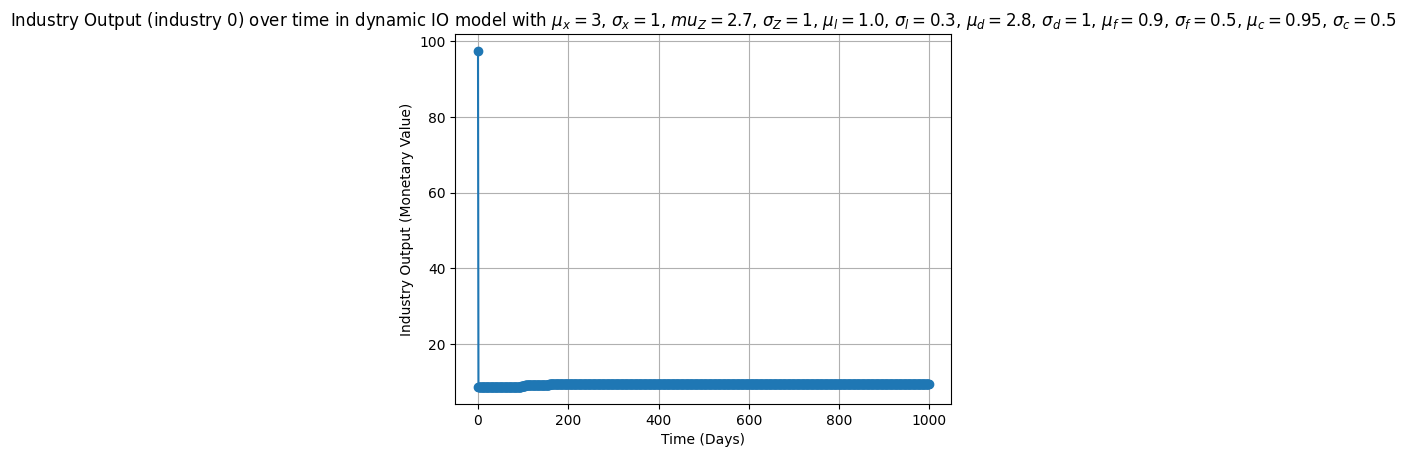

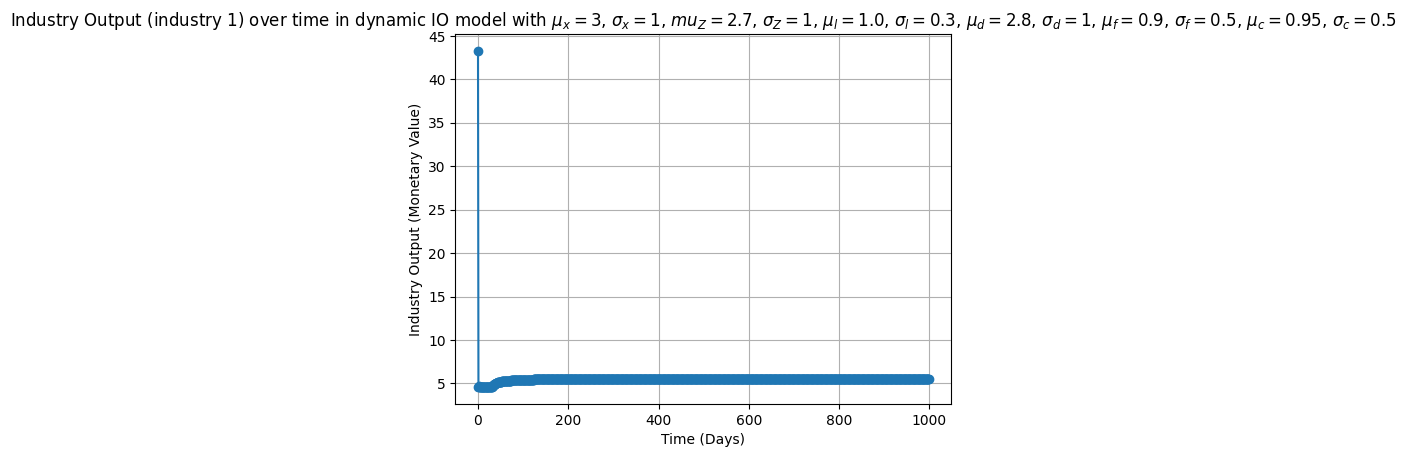

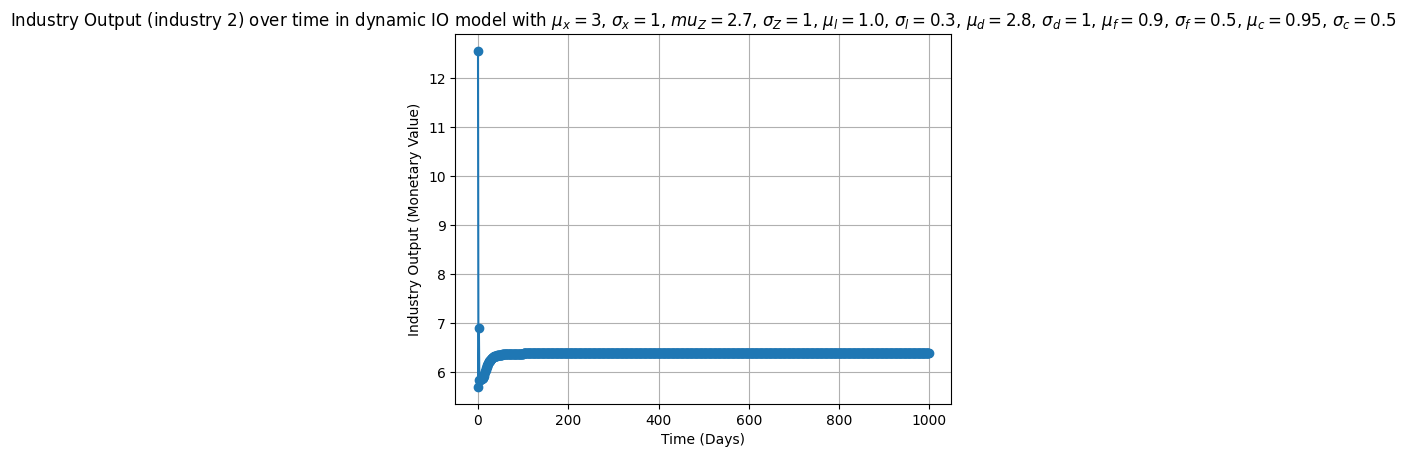

{0: array([97.43766259, 43.26892583, 12.56010617]),
 1: array([8.69035231, 4.5953425 , 5.70028557]),
 2: array([8.69035231, 4.70779094, 6.90889587]),
 3: array([8.69035231, 4.5953425 , 5.83485088]),
 4: array([8.69035231, 4.5953425 , 5.84290596]),
 5: array([8.69035231, 4.5953425 , 5.85015554]),
 6: array([8.69035231, 4.5953425 , 5.85668016]),
 7: array([8.69035231, 4.5953425 , 5.86255232]),
 8: array([8.69035231, 4.5953425 , 5.86783726]),
 9: array([8.69035231, 4.5953425 , 5.8725937 ]),
 10: array([8.69035231, 4.5953425 , 5.87687451]),
 11: array([8.69035231, 4.5953425 , 5.88072723]),
 12: array([8.69035231, 4.5953425 , 5.89428244]),
 13: array([8.69035231, 4.5953425 , 5.93159715]),
 14: array([8.69035231, 4.5953425 , 5.96583802]),
 15: array([8.69035231, 4.5953425 , 5.99828974]),
 16: array([8.69035231, 4.5953425 , 6.02751711]),
 17: array([8.69035231, 4.5953425 , 6.05390834]),
 18: array([8.69035231, 4.5953425 , 6.07764251]),
 19: array([8.69035231, 4.5953425 , 6.09899155]),
 20: ar

In [10]:
x = run_model(days=1000)    
plot_results(days=1000, x=x, x_mean=3, x_sigma=1, Z_mean=2.7, Z_sigma=1, industry_labour_comp_mean=1.0, industry_labour_comp_sigma=0.3, industry_demand_mean=2.8, industry_demand_sigma=1, demand_non_household_final_demand_mean=0.9, demand_non_household_final_demand_sigma=0.5, demand_household_consumption_mean=0.95, demand_household_consumption_sigma=0.5)

x

In [11]:
industry_demand

{0: array([15.88456393, 51.12835652, 14.80928652]),
 1: array([8.69035231, 4.5953425 , 5.70028557]),
 2: array([8.69035231, 4.70779094, 6.90889587]),
 3: array([8.69035231, 4.5953425 , 5.83485088]),
 4: array([8.69035231, 4.5953425 , 5.84290596]),
 5: array([8.69035231, 4.5953425 , 5.85015554]),
 6: array([8.69035231, 4.5953425 , 5.85668016]),
 7: array([8.69035231, 4.5953425 , 5.86255232]),
 8: array([8.69035231, 4.5953425 , 5.86783726]),
 9: array([8.69035231, 4.5953425 , 5.8725937 ]),
 10: array([8.69035231, 4.5953425 , 5.87687451]),
 11: array([8.69035231, 4.5953425 , 5.88072723]),
 12: array([8.69035231, 4.5953425 , 5.89428244]),
 13: array([8.69035231, 4.5953425 , 5.93159715]),
 14: array([8.69035231, 4.5953425 , 5.96583802]),
 15: array([8.69035231, 4.5953425 , 5.99828974]),
 16: array([8.69035231, 4.5953425 , 6.02751711]),
 17: array([8.69035231, 4.5953425 , 6.05390834]),
 18: array([8.69035231, 4.5953425 , 6.07764251]),
 19: array([8.69035231, 4.5953425 , 6.09899155]),
 20: ar

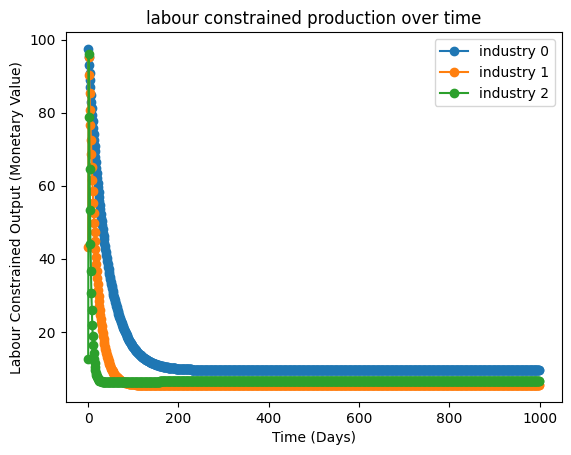

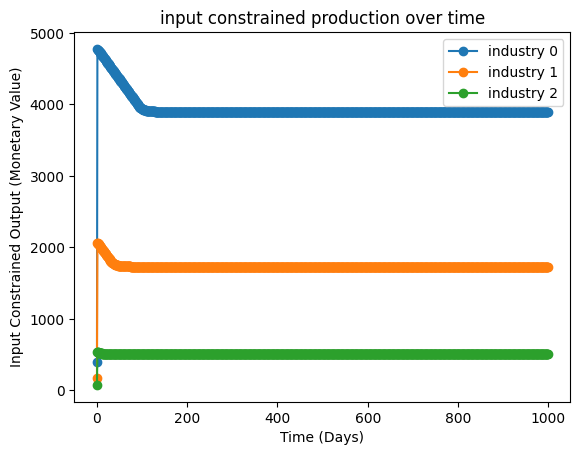

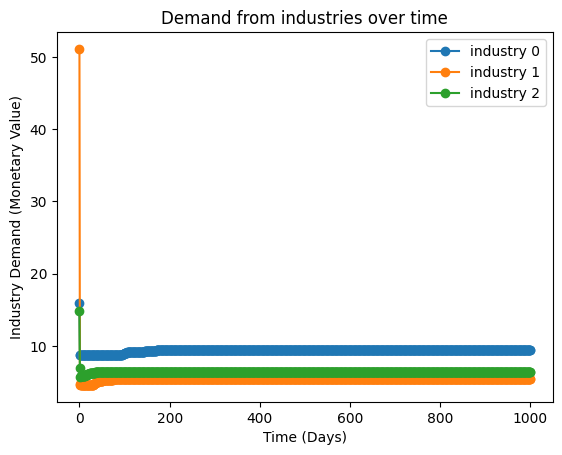

({0: array([97.43766259, 43.26892583, 12.56010617]),
  1: array([95.21897984, 95.2604283 , 96.1072501 ]),
  2: array([93.05576415, 90.16252192, 78.80787575]),
  3: array([90.94662885, 85.34528542, 64.65528643]),
  4: array([88.89022194, 80.79924831, 53.24905147]),
  5: array([86.8852252 , 76.5091427 , 44.05637912]),
  6: array([84.93035337, 72.46056022, 36.64782435]),
  7: array([83.02435335, 68.63990368, 30.67724395]),
  8: array([81.16600332, 65.03434136, 25.86563932]),
  9: array([79.35411205, 61.63176395, 21.98813302]),
  10: array([77.58751805, 58.42074387, 18.8634712 ]),
  11: array([75.86508891, 55.39049687, 16.34556209]),
  12: array([74.18572049, 52.53084585, 14.31861215]),
  13: array([72.54833629, 49.83218665, 12.69201137]),
  14: array([70.95188669, 47.28545578, 11.3875188 ]),
  15: array([69.39534833, 44.88210004, 10.34231688]),
  16: array([67.87772343, 42.61404773,  9.50549273]),
  17: array([66.39803915, 40.47368158,  8.83608296]),
  18: array([64.95534698, 38.45381314,

In [12]:
labour_constrained_productions = {}
input_constrained_productions = {}

for i in range(num_industries):
    labour_constrained_productions[i] = []
    input_constrained_productions[i] = []
    

time_axis = np.arange(start = 0, stop=1000, step=1)

for time, labour_constrained_production in labour_constrained_x.items():
    for i in range(num_industries):
        labour_constrained_productions[i].append(labour_constrained_production[i])

for time, input_constrained_production in input_constrained_x.items():
    for i in range(num_industries):
        input_constrained_productions[i].append(input_constrained_production[i])
        
for j in range(num_industries):
    plt.plot(time_axis, labour_constrained_productions[j], marker='o', label='industry {}'.format(str(j)))

plt.title('labour constrained production over time')
plt.xlabel('Time (Days)')
plt.ylabel('Labour Constrained Output (Monetary Value)')
plt.legend()
plt.show()

for j in range(num_industries):
    plt.plot(time_axis, input_constrained_productions[j], marker='o', label='industry {}'.format(str(j)))

plt.title('input constrained production over time')
plt.xlabel('Time (Days)')
plt.ylabel('Input Constrained Output (Monetary Value)')
plt.legend()

plt.show()

# Orders from industry 0 to industry 1 and 2 are very high j which must be due to industry demand of industry 1 and 2

industry_demands = {}
for i in range(num_industries):
    industry_demands[i] = []

for time, demand in industry_demand.items():
    for j in range(num_industries):
        industry_demands[j].append(demand[j])

for j in range(num_industries):
    plt.plot(np.arange(len(industry_demands[j])), industry_demands[j], marker='o', label = 'industry {}'.format(str(j)))

plt.title('Demand from industries over time')
plt.xlabel('Time (Days)')
plt.ylabel('Industry Demand (Monetary Value)')
plt.legend()
plt.show()

labour_constrained_x, input_constrained_x


In [13]:
for i in range(num_industries):
    industry_demands[i].pop()

In [14]:
labour_constrained_x[0], industry_demand[1], input_constrained_x[0] 

(array([97.43766259, 43.26892583, 12.56010617]),
 array([8.69035231, 4.5953425 , 5.70028557]),
 array([389.75065037, 173.07570333,  75.36063702]))

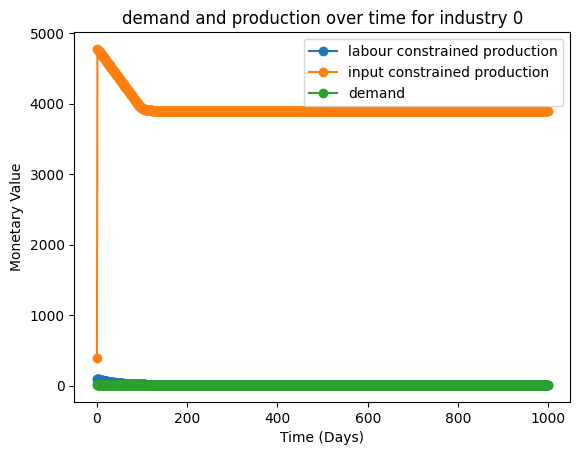

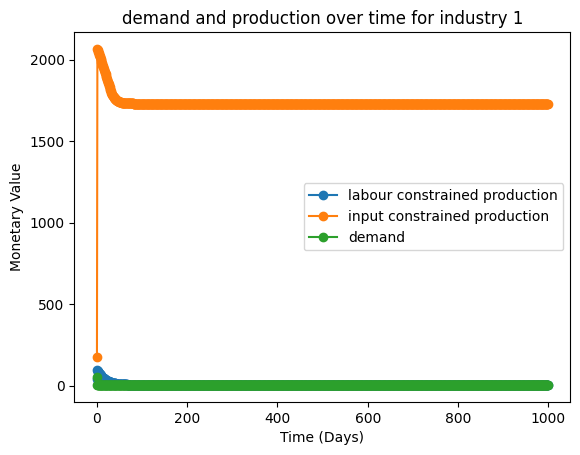

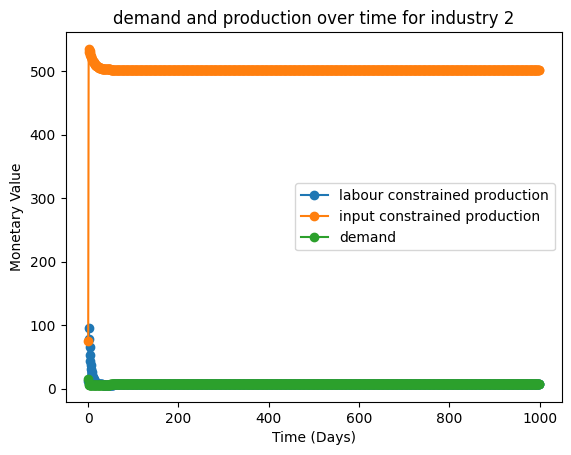

In [15]:
for j in range(num_industries):
    plt.plot(time_axis, labour_constrained_productions[j], marker='o', label='labour constrained production')
    plt.plot(time_axis, input_constrained_productions[j], marker='o', label='input constrained production')
    plt.plot(time_axis, industry_demands[j], marker='o', label='demand')
    plt.title('demand and production over time for industry {}'.format(j))
    plt.xlabel('Time (Days)')
    plt.ylabel('Monetary Value')
    plt.legend()
    plt.show()
    

In [16]:
# industry_outlooks_dict = {}
# for i in range(num_industries):
#     industry_outlooks_dict[i] = []

# for time, outlooks in industry_outlooks.items():
#     for i in range(num_industries):
#         industry_outlooks_dict[i].append(outlooks[i])

# for j in range(num_industries):
#     plt.plot(np.arange(len(industry_outlooks[0])), industry_demands[j], marker='o', label='demand')
#     plt.title('Industry Outlooks over time'.format(j))
#     plt.xlabel('Time (Days)')
#     plt.ylabel('Industry Outlook Measure')
#     plt.legend()
#     plt.show()

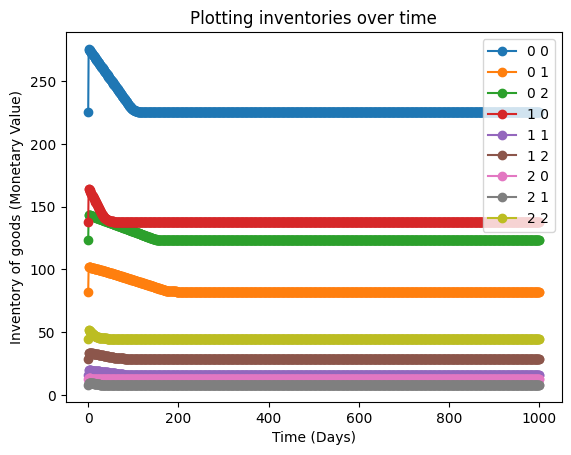

In [17]:
inventories = dict()

inventories['0 0'] = []
inventories['0 1'] = []
inventories['0 2'] = []
inventories['1 0'] = []
inventories['1 1'] = []
inventories['1 2'] = []
inventories['2 0'] = []
inventories['2 1'] = []
inventories['2 2'] = []

good_i_to_industry_j = ['0 0', '0 1', '0 2', '1 0', '1 1', '1 2', '2 0', '2 1', '2 2']

for time, inv in S.items():
    for inter_industries in good_i_to_industry_j:
        
        good_provider = int(inter_industries.split(' ')[0])
        good_receiver = int(inter_industries.split(' ')[1])
        # inventories[inter_industries] = []
        inventories[inter_industries].append(inv[good_provider][good_receiver]) 
    
time_axis = np.arange(start = 0, stop=1001, step=1)

for inter_industries in good_i_to_industry_j:
    plt.plot(time_axis, inventories[inter_industries], marker='o', label= inter_industries)
    plt.title('Plotting inventories over time')
    plt.xlabel('Time (Days)')
    plt.ylabel('Inventory of goods (Monetary Value)')

plt.legend()

plt.show()


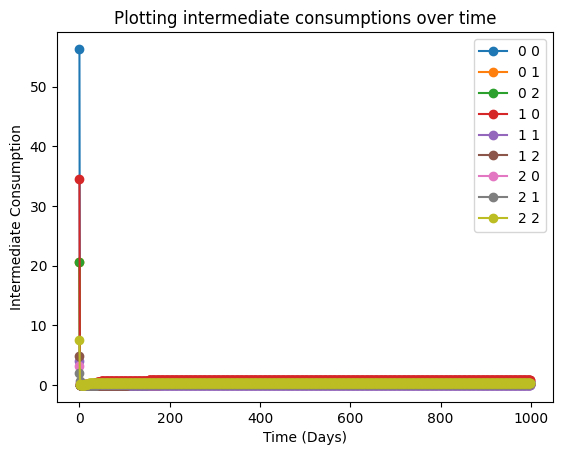

In [18]:
intermediate_consumptions = dict()

intermediate_consumptions['0 0'] = []
intermediate_consumptions['0 1'] = []
intermediate_consumptions['0 2'] = []
intermediate_consumptions['1 0'] = []
intermediate_consumptions['1 1'] = []
intermediate_consumptions['1 2'] = []
intermediate_consumptions['2 0'] = []
intermediate_consumptions['2 1'] = []
intermediate_consumptions['2 2'] = []

intermediate_consumptions_paths = ['0 0', '0 1', '0 2', '1 0', '1 1', '1 2', '2 0', '2 1', '2 2']

for time, inv in Z.items():
    for inter_industries in intermediate_consumptions_paths:
        good_provider = int(inter_industries.split(' ')[0])
        good_receiver = int(inter_industries.split(' ')[1])
        intermediate_consumptions[inter_industries].append(inv[good_provider][good_receiver])

time_axis = np.arange(start = 0, stop=1000, step=1)

for inter_industries in intermediate_consumptions_paths:
    plt.plot(time_axis, intermediate_consumptions[inter_industries], marker='o', label=inter_industries)
    plt.title('Plotting intermediate consumptions over time')
    plt.xlabel('Time (Days)')
    plt.ylabel('Intermediate Consumption')

plt.legend()

plt.show()

{1: array([[0.        , 0.        , 0.        ],
        [0.        , 0.11244844, 0.        ],
        [0.32348357, 0.67666728, 0.20845945]]),
 2: array([[0.       , 0.       , 0.       ],
        [0.       , 0.       , 0.       ],
        [0.1345653, 0.       , 0.       ]]),
 3: array([[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.14262039, 0.        , 0.        ]]),
 4: array([[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.14986997, 0.        , 0.        ]]),
 5: array([[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.15639459, 0.        , 0.        ]]),
 6: array([[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.16226674, 0.        , 0.        ]]),
 7: array([[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.16755168, 0.        , 0.        ]]),
 8: arra

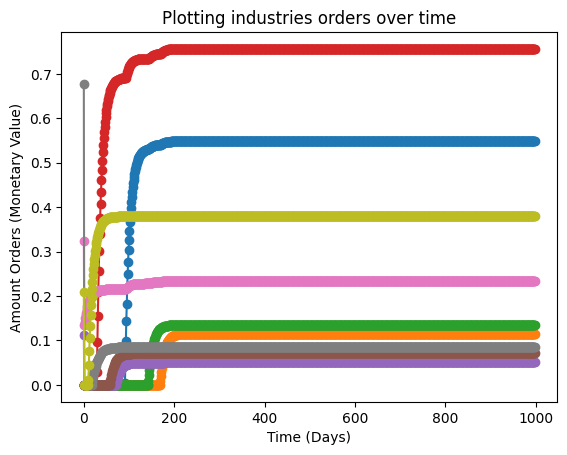

In [19]:
intermediate_orders = dict()

intermediate_orders['0 0'] = []
intermediate_orders['0 1'] = []
intermediate_orders['0 2'] = []
intermediate_orders['1 0'] = []
intermediate_orders['1 1'] = []
intermediate_orders['1 2'] = []
intermediate_orders['2 0'] = []
intermediate_orders['2 1'] = []
intermediate_orders['2 2'] = []

intermediate_orders_paths = ['0 0', '0 1', '0 2', '1 0', '1 1', '1 2', '2 0', '2 1', '2 2']


for time, inv in industry_orders.items():
    for inter_industries in intermediate_orders_paths:
        
        good_provider = int(inter_industries.split(' ')[0])
        good_receiver = int(inter_industries.split(' ')[1])
        
        intermediate_orders[inter_industries].append(inv[good_provider][good_receiver])

time_axis = np.arange(start = 0, stop=999, step=1)

for inter_industries in intermediate_orders_paths:
    plt.plot(time_axis, intermediate_orders[inter_industries], marker='o', label=inter_industries)
    plt.title('Plotting industries orders over time')
    plt.xlabel('Time (Days)')
    plt.ylabel('Amount Orders (Monetary Value)')
    
# plt.plot(time_axis, intermediate_orders['0 2'], marker='o', label=inter_industries)
# plt.title('Plotting industries orders (0 -> 1) over time')
# plt.xlabel('Time (Days)')
# plt.ylabel('Amount Orders (Monetary Value)')

industry_orders


In [20]:
def np_to_df(np_data):
    df = pd.DataFrame(np_data)
    
    df = df.T
    
    return df

def mult_np_to_list_df(mult_np_data):
    dataframes = []
    
    for day, data in mult_np_data.items():
        dataframes.append(pd.DataFrame(data)) 
    
    return dataframes

In [21]:
#---
A = IO_matrix
A = A.astype(np.float64)
A = A/10



eigenvalues, eigenvectors = np.linalg.eig( np.linalg.inv(np.eye(num_industries) -  A) )

np.sum(np.linalg.inv(np.eye(num_industries) -  A), axis=0)


array([1.01637188, 1.0046669 , 1.00926425])

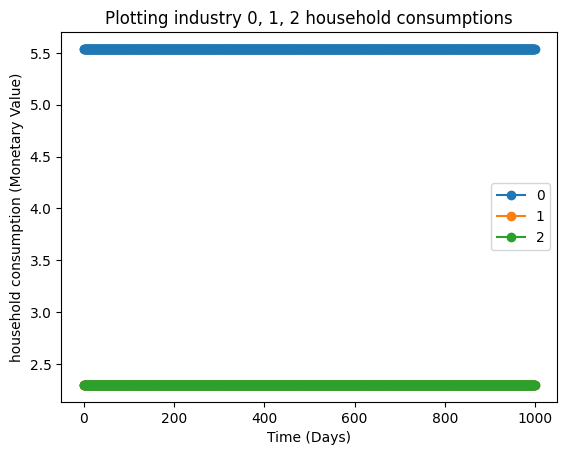

In [22]:

demand_non_household_final_demands = dict()

demand_non_household_final_demands[0] = []
demand_non_household_final_demands[1] = []
demand_non_household_final_demands[2] = []

demand_household_consumptions = dict()

demand_household_consumptions[0] = []
demand_household_consumptions[1] = []
demand_household_consumptions[2] = []


for time, f in demand_non_household_final_demand.items():
   demand_non_household_final_demands[0].append(f[0])
   demand_non_household_final_demands[1].append(f[1])
   demand_non_household_final_demands[2].append(f[2])
   
for time, c in demand_household_consumption.items():
   demand_household_consumptions[0].append(c[0])
   demand_household_consumptions[1].append(c[1])
   demand_household_consumptions[2].append(c[2])
   
# plt.plot(np.arange(start=0, stop=len(demand_household_consumption[0])), demand_non_household_final_demands[0], marker='.', label=0)
# plt.title('Plotting industry 0 final non household demands')
# plt.xlabel('Time (Days)')
# plt.ylabel('demand non household final demand (Monetary Value)')


for i in range(3):
   plt.plot(np.arange(start=0, stop=len(demand_household_consumptions[i])), demand_household_consumptions[i], marker='o', label=i)
   plt.title('Plotting industry 0, 1, 2 household consumptions')
   plt.xlabel('Time (Days)')
   plt.ylabel('household consumption (Monetary Value)')

plt.legend()
plt.show()

Comparing idealised demand with actual empirical demands

In [23]:


# asymptotic_c = demand_non_household_final_demand[-1]
asymptotic_f = demand_non_household_final_demand[499]
# asymptotic_c = demand_household_consumption

asymptotic_c = demand_household_consumption[499]

I = np.eye(A.shape[0])
inv_I_minus_A = np.linalg.inv(I - A)

external_demands = asymptotic_c + asymptotic_f



idealised_demands = np.matmul(inv_I_minus_A, external_demands)

# idealised_demands

idealised_demands[0]


8.763022208603141

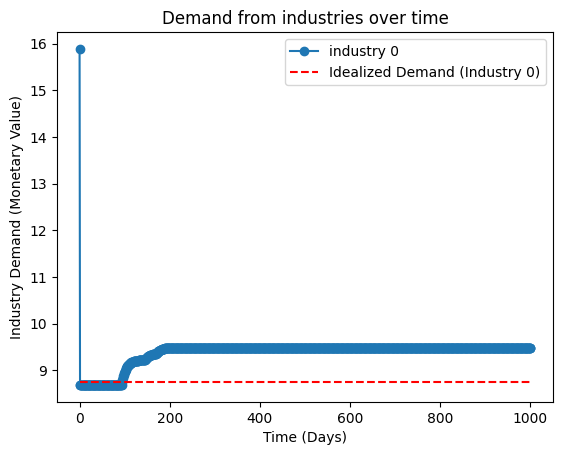

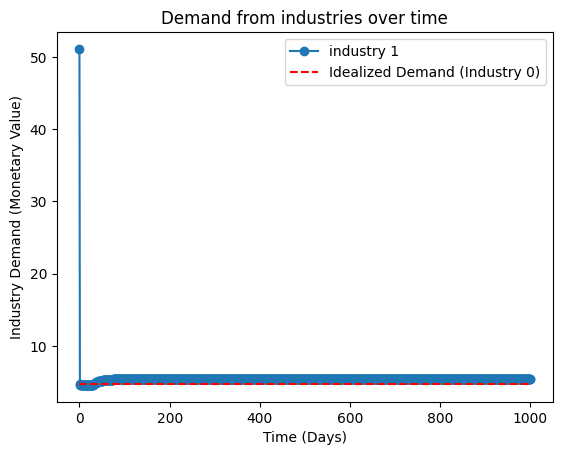

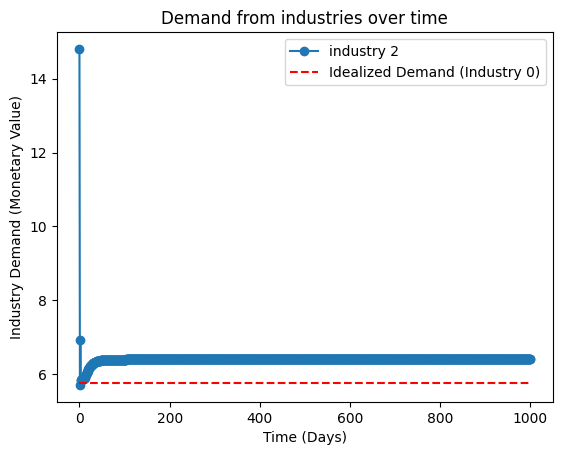

In [24]:
industry_demands = {}
for i in range(num_industries):
    industry_demands[i] = []

for time, demand in industry_demand.items():
    for j in range(num_industries):
        industry_demands[j].append(demand[j])

# for j in range(num_industries):
#     plt.plot(np.arange(len(industry_demands[j])), industry_demands[j], marker='o', label = 'industry {}'.format(str(j)))

for j in range(num_industries):
    plt.plot(np.arange(len(industry_demands[j])), industry_demands[j], marker='o', label = 'industry {}'.format(str(j)))
    plt.plot(np.arange(len(industry_demands[j])), [idealised_demands[j]] * len(industry_demands[j]), linestyle='--', label='Idealized Demand (Industry 0)', color='red')
    plt.title('Demand from industries over time')
    plt.xlabel('Time (Days)')
    plt.ylabel('Industry Demand (Monetary Value)')
    plt.legend()
    plt.show()


In [25]:
with open('industry_outputs_300.json', 'w') as f:
    json.dump(x[500].tolist(), f)

with open('input_constrained_outputs_300.json', 'w') as f:
    json.dump(input_constrained_x[500].tolist(), f)

with open('input_constrained_outputs_299.json', 'w') as f:
    json.dump(input_constrained_x[499].tolist(), f)

with open('labour_constrained_outputs_300.json', 'w') as f:
    json.dump(labour_constrained_x[500].tolist(), f)

with open('labour_constrained_outputs_299.json', 'w') as f:
    json.dump(labour_constrained_x[499].tolist(), f)

with open('industry_demand_300.json', 'w') as f:
    json.dump(industry_demand[500].tolist(), f)

with open('industry_demand_299.json', 'w') as f:
    json.dump(industry_demand[499].tolist(), f)

with open('intermediate_consumption.json', 'w') as f:
    json.dump(Z[500].tolist(), f)

with open('industry_orders.json', 'w') as f:
    json.dump(industry_orders[500].tolist(), f)

with open('inventories_299.json', 'w') as f:
    json.dump(S[499].tolist(), f)

with open('inventories_300.json', 'w') as f:
    json.dump(S[500].tolist(), f)

with open('target_inventories.json', 'w') as f:
    json.dump(target_inventory.tolist(), f)

with open('non_household_final_demand.json', 'w') as file:
    json.dump(demand_non_household_final_demand[500].tolist(), file)

with open('demand_household_consumption.json', 'w') as f:
    json.dump(demand_household_consumption[500].tolist(), f)

with open('industry_labour_comp_300.json', 'w') as f:
    json.dump(industry_labour_comp[500].tolist(), f)

with open('industry_labour_comp_299.json', 'w') as f:
    json.dump(industry_labour_comp[499].tolist(), f)

with open('industry_outlooks.json', 'w') as f:
    json.dump(industry_outlooks[500].tolist(), f)

In [26]:
inventory_adjustment, downward_labour_adjustment, upward_labour_adjustment, consumption_adjustment, initial_total_labour_compensation, total_labour_compensation, total_permanent_labour_compensation, Labour_share = set_coefficients(initial_industry_labour_comp=initial_industry_labour_comp, x_initial=x_initial)

constants = {
    "inventory_adjustment": inventory_adjustment,
    "downward_labour_adjustment": downward_labour_adjustment,
    "upward_labour_adjustment": upward_labour_adjustment,
    "consumption_adjustment": consumption_adjustment,
    "initial_total_labour_compensation": initial_total_labour_compensation,
    "total_labour_compensation": total_labour_compensation,
    "total_permanent_labour_compensation": total_permanent_labour_compensation,
    "Labour_share": Labour_share.tolist(),
    "initial_industry_labour_comp": initial_industry_labour_comp.tolist(),
    "IO_matrix": IO_matrix.tolist(),
    "initial_labour_constrained_outputs": initial_labour_constrained_outputs
}

with open('constants.json', 'w') as f:
    json.dump(constants, f)

IO_matrix

array([[0.05778579, 0.02113151, 0.02108271],
       [0.07963256, 0.00922743, 0.01114001],
       [0.02475345, 0.01577492, 0.05947164]])

array([9.4893266 , 5.47282327, 6.40226566])